# Table of Contents

1. Word Embeddings
2. Attention Translation Models

## Install Libraires

In [2]:
# install gensim libraries
!pip install gensim
!pip install google-compute-engine

# afterwards, you need to reinstall python-boto package because of circular installation with google-compute-engine
# sudo apt-get remove python-boto
# sudo apt-get install python-boto

# install the open source neural machine translation system library
!pip install git+git://github.com/OpenNMT/OpenNMT-tf.git

In [1]:
# general libraries
import datetime 
import numpy as np 
import pandas as pd
import re

from nltk.corpus import stopwords

# model definition
from gensim.models import Word2Vec

# reduce feature sets
from sklearn.decomposition import PCA

# data visualization
from matplotlib import pyplot
%matplotlib inline

# opennmt
from opennmt import constants
from opennmt.utils.misc import count_lines

# define current time now to be used as saving the model
now = datetime.datetime.now()

In [61]:
# define the region
# also defined in tweets_processor.py but listed here for my own reference
region2idx = {
    "albuquerque":0,
    "billings":1,
    "calgary":2,
    "charlotte":3,
    "chicago":4,
    "cincinnati":5,
    "denver":6,
    "houston":7,
    "kansas city":8,
    "las vegas":9,
    "los angeles":10,
    "minneapolis":11,
    "montreal":12,
    "nashville":13,
    "new york":14,
    "oklahoma city":15,
    "phoenix":16,
    "pittsburgh":17,
    "san francisco":18,
    "seattle":19,
    "tampa":20,
    "toronto":21,
    "washington":22
}
idx2region = {
    0:"albuquerque",
    1:"billings",
    2:"calgary",
    3:"charlotte",
    4:"chicago",
    5:"cincinnati",
    6:"denver",
    7:"houston",
    8:"kansas city",
    9:"las vegas",
    10:"los angeles",
    11:"minneapolis",
    12:"montreal",
    13:"nashville",
    14:"new york",
    15:"oklahoma city",
    16:"phoenix",
    17:"pittsburgh",
    18:"san francisco",
    19:"seattle",
    20:"tampa",
    21:"toronto",
    22:"washington"
}

# Word Embedding

We started of with word embeddings because back-propagation is possible over continuous representations than discrete ones. 

Word embeddings overcome the many limitations that Bag of Words produced, in particular large sparse vectors that do not describe the meaning of the words. It provides a projection in the vector space where words with similar meanings cluster together. There are two main algorithms used for training the word vectors: Continuous Bag of Words (CBOW), which predicts the word given its context, and Skip-gram, which predicts the context given the word. We will employ the latter than the former because we have limited training data. Even though CBOW trains several times faster than Skip-gram and is slightly better in terms of accuracy for the frequency of words, it also requires a larger text corpus ranging from 1-100B words. Currently our training data is limited to 767,446 words.

GloVe is another successful word embedding algorithms with generally better word embeddings because it combines both the global statistics of matrix factorization techniques like LSA with the local context-based learning in Word2Vec. Since we would like the word embeddings to learn from live Twitter feeds used, we will stick with Word2Vec.

### Notes to self

The problem with word embedding is that you have to know the pair of words in advance.

Also, for classification tasks, fasttext performs faster than word2vec, might want to check this out later.

How to transfer learning and word embeddings:
1. Learn word embeddings from large text corpus (1-100B words)
2. Transfer embedding to a new task with smaller training set
3. Continue to finetune word embeddings with new data


### References

* https://www.youtube.com/watch?v=5PL0TmQhItY&t=583s
* using gensim: https://machinelearningmastery.com/what-are-word-embeddings/
* using tensorflow: https://medium.com/deep-math-machine-learning-ai/chapter-9-2-nlp-code-for-word2vec-neural-network-tensorflow-544db99f5334

In [2]:
# retrieve the datasets
df = pd.read_csv("/var/data/tweets_labelled.csv", sep=",")
df.head()

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


text region
0  does anyone live in the Charleston area and wa...      3
1               You followed my friends to watch me😐      3
2  Not a totally new subscriber, but just a few d...     20
3                                       no he doodoo     10
4                        Wait that's  not an Anime!!     13

In [14]:
df_40k = pd.read_csv("/var/data/tweets_labelled_40k.csv", sep=",")
df_40k.head()

text  region
0  does anyone live in the Charleston area and wa...       3
1               You followed my friends to watch me😐       3
2  Not a totally new subscriber, but just a few d...      13
3                                       no he doodoo      10
4                        Wait that's  not an Anime!!      13

## Word embeddings for the entire dataset

In [3]:
# convert each tweet to a list of words
sentences = list()
for sentence in df.text.tolist():
    word_list = re.sub("[^\w]", " ", sentence).split()
    sentences.append(word_list)
sentences[0:5]

[['does',
  'anyone',
  'live',
  'in',
  'the',
  'Charleston',
  'area',
  'and',
  'want',
  'a',
  'job',
  '10',
  'hr',
  'for',
  'Nov',
  '14',
  '21',
  'hmu'],
 ['You', 'followed', 'my', 'friends', 'to', 'watch', 'me'],
 ['Not',
  'a',
  'totally',
  'new',
  'subscriber',
  'but',
  'just',
  'a',
  'few',
  'days',
  'into',
  'it'],
 ['no', 'he', 'doodoo'],
 ['Wait', 'that', 's', 'not', 'an', 'Anime']]

In [4]:
# train the model 
model = Word2Vec(sentences, min_count=1)
model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))
print(model)

Word2Vec(vocab=767446, size=100, alpha=0.025)


In [ ]:
# load the model
# 40k: /var/data/word_embeddings_20181127_054247
# 2.5M: /var/data/word_embeddings_20181127_070749
"""
model = Word2Vec.load('/var/data/word_embeddings_20181127_070749')
"""

In [5]:
# list the words
words = list(model.wv.vocab)
words[0:5]

['does', 'anyone', 'live', 'in', 'the']

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


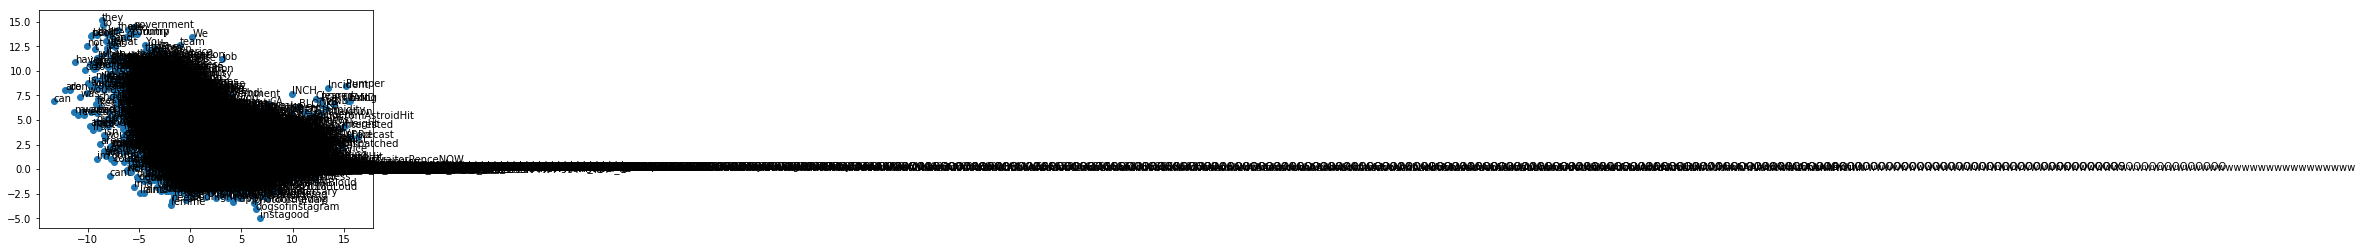

In [6]:
# retrieve all of the vectors from the trained model
x  = model[model.wv.vocab]

# fit a 2D PCA model to the vectors 
pca = PCA(n_components=2)
result = pca.fit_transform(x)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
pyplot.savefig('imgs/word2vec_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

# 2.5M: ~/w266-final/divya-models/word2vec_20181127_070749.png

In [26]:
# create a dictionary with frequency of words
unique_words = set(words)
unique_words_count = dict()
for word in unique_words:
    unique_words_count[word] = model.wv.vocab[word].count
unique_words_count = dict(sorted(unique_words_count.items(), key=lambda v: v[1], reverse=True))

In [33]:
# create a copy of that dictionary
unique_words_count_without_stopwords = unique_words_count.copy()

# filter out stopwords from the dictionary
stop_words = set(stopwords.words('english')) 
for key in unique_words_count.keys():
    if key.lower() in stop_words:
        unique_words_count_without_stopwords.pop(key, None)

In [34]:
# remove approximately 858 words
len(unique_words_count) - len(unique_words_count_without_stopwords)

858

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


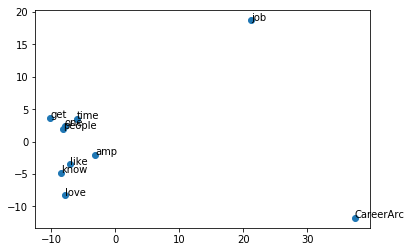

<Figure size 432x288 with 0 Axes>

In [47]:
# show the top 10 most frequent words 

# retrieve all of the vectors from the trained model
top10 = list(unique_words_count_without_stopwords)[:10]
top10_x  = model[top10]

# fit a 2D PCA model to the vectors 
pca = PCA(n_components=2)
result = pca.fit_transform(top10_x)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(top10):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
pyplot.savefig('imgs/word2vec_top10_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

## Word embeddings for each region

Redo the entire word embeddings done above into an encapsulated function

In [67]:
def plot_word_embeddings(data, region):
    
    # convert each tweet to a list of words
    sentences = list()
    for sentence in data:
        word_list = re.sub("[^\w]", " ", sentence).split()
        sentences.append(word_list)

    # train the model 
    model = Word2Vec(sentences, min_count=1)
    model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

    # list the words
    words = list(model.wv.vocab)
    
    # create a dictionary with frequency of words
    unique_words = set(words)
    unique_words_count = dict()
    for word in unique_words:
        unique_words_count[word] = model.wv.vocab[word].count
    unique_words_count = dict(sorted(unique_words_count.items(), key=lambda v: v[1], reverse=True))
    
    # create a copy of that dictionary
    unique_words_count_without_stopwords = unique_words_count.copy()

    # filter out stopwords from the dictionary
    stop_words = set(stopwords.words('english')) 
    for key in unique_words_count.keys():
        if key.lower() in stop_words:
            unique_words_count_without_stopwords.pop(key, None)

    # retrieve all of the vectors from the trained model
    top10 = list(unique_words_count_without_stopwords)[:10]
    top10_x  = model[top10]

    # fit a 2D PCA model to the vectors 
    pca = PCA(n_components=2)
    result = pca.fit_transform(top10_x)
    pyplot.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(top10):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
    pyplot.savefig('imgs/word2vec_top10_region{}_{}'.format(region, now.strftime('%Y%m%d_%H%M%S')))

Region 0: albuquerque


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


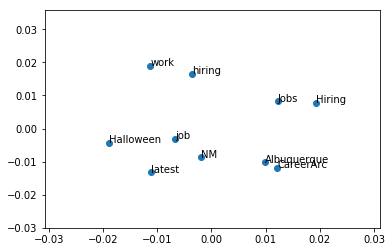

Region 1: billings


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


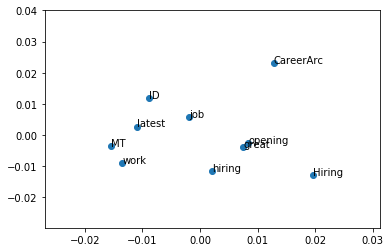

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Region 2: calgary


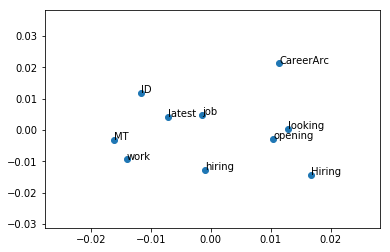

Region 3: charlotte


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


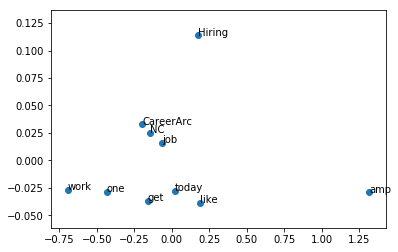

Region 4: chicago


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


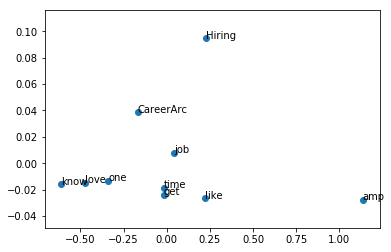

Region 5: cincinnati


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


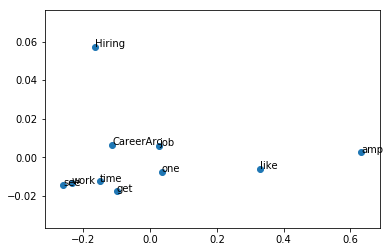

Region 6: denver


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


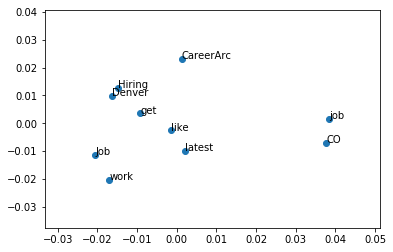

Region 7: houston


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


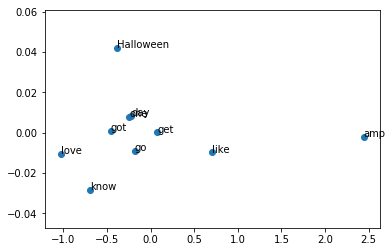

Region 8: kansas city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


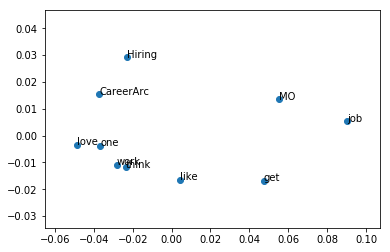

Region 9: las vegas


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


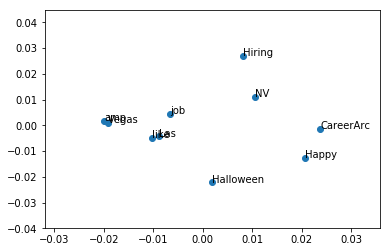

Region 10: los angeles


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


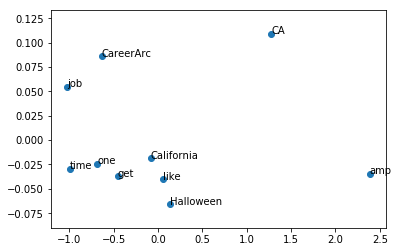

Region 11: minneapolis


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


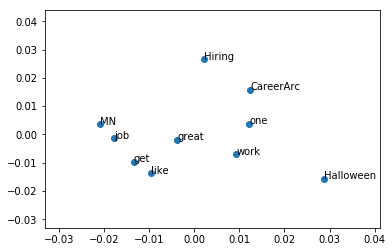

Region 12: montreal


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


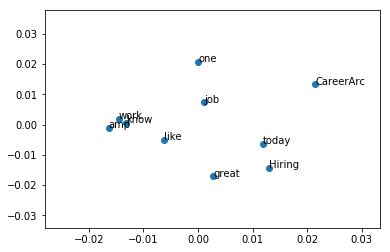

Region 13: nashville


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


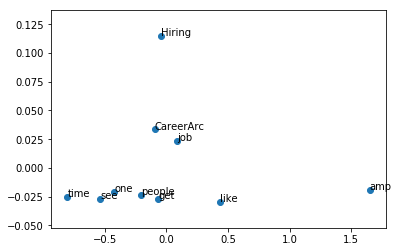

Region 14: new york


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


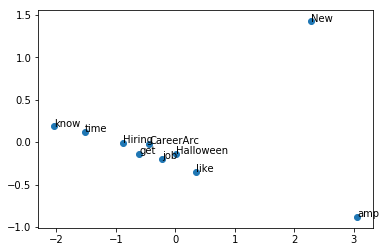

Region 15: oklahoma city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


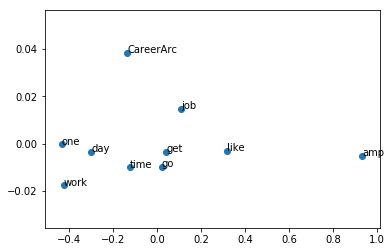

Region 16: phoenix


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


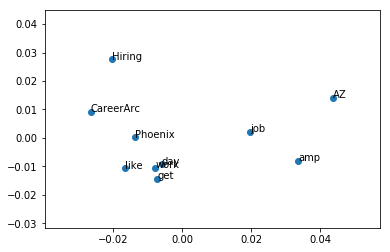

Region 17: pittsburgh


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


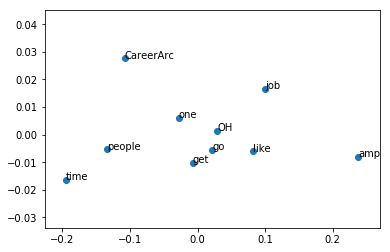

Region 18: san francisco


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


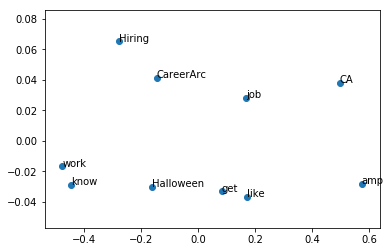

Region 19: seattle


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


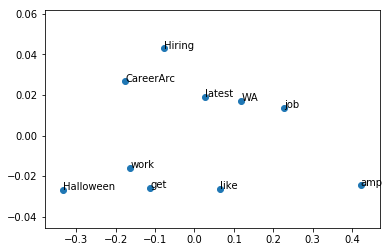

Region 20: tampa


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


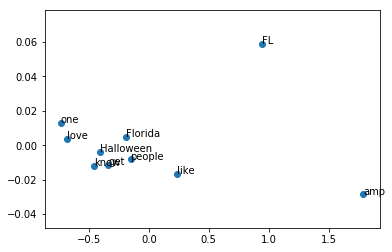

Region 21: toronto


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


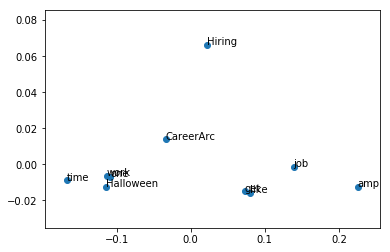

Region 22: washington


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


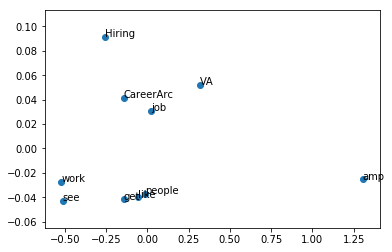

<Figure size 432x288 with 0 Axes>

In [69]:
# with 40K dataset
for region in regions_mapping.values():
    print('Region {}: {}'.format(region, idx2region[region]))
    data = df_40k.loc[df_40k.region == region]
    plot_word_embeddings(data.text.tolist(), region)

Region 0: albuquerque


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


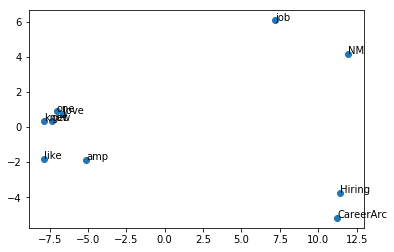

Region 1: billings


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


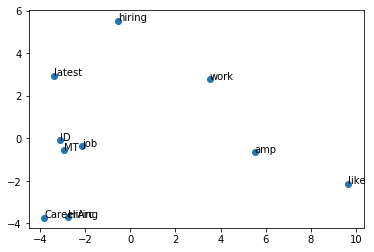

Region 2: calgary


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


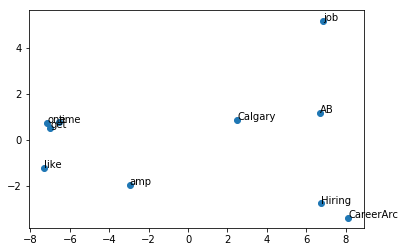

Region 3: charlotte


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


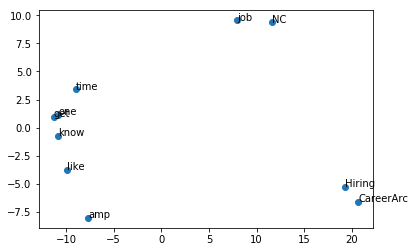

Region 4: chicago


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


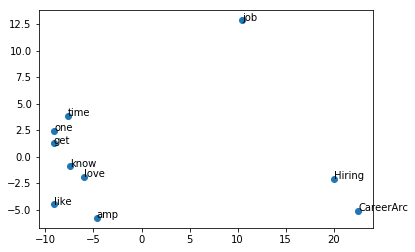

Region 5: cincinnati


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


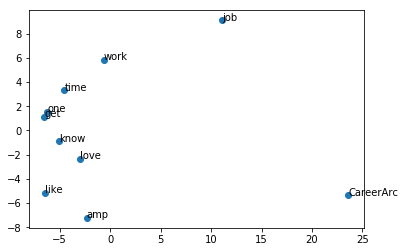

Region 6: denver


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


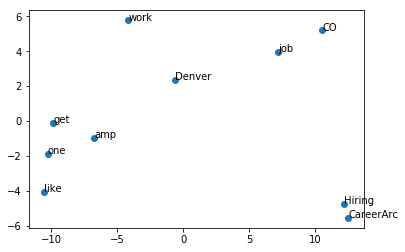

Region 7: houston


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


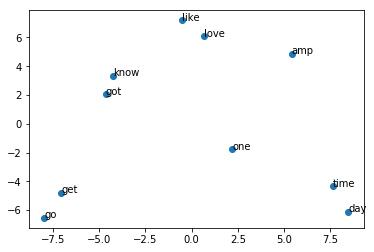

Region 8: kansas city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


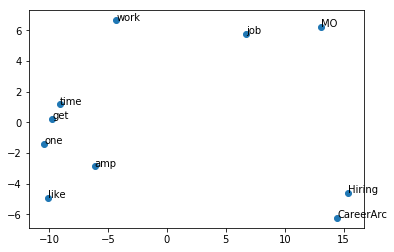

Region 9: las vegas


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


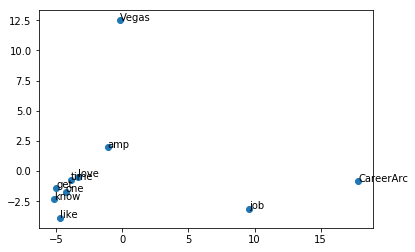

Region 10: los angeles


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


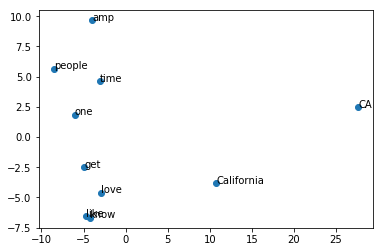

Region 11: minneapolis


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


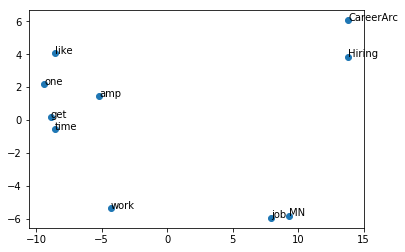

Region 12: montreal


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


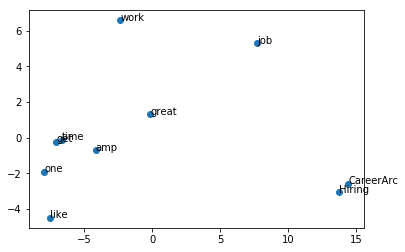

Region 13: nashville


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


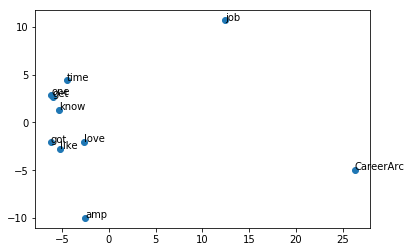

Region 14: new york


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


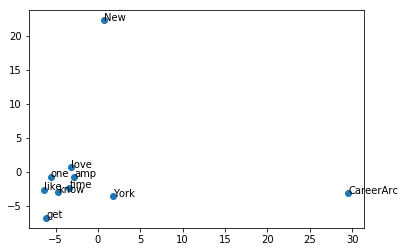

Region 15: oklahoma city


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


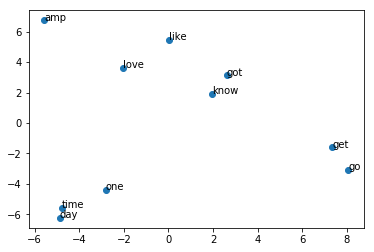

Region 16: phoenix


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


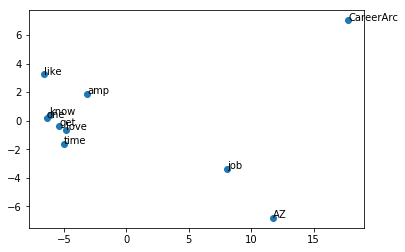

Region 17: pittsburgh


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


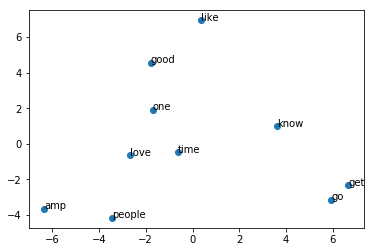

Region 18: san francisco


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


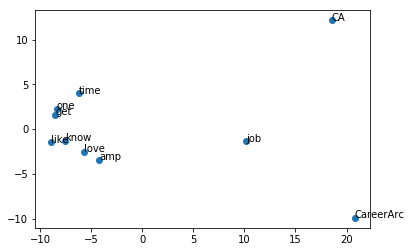

Region 19: seattle


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


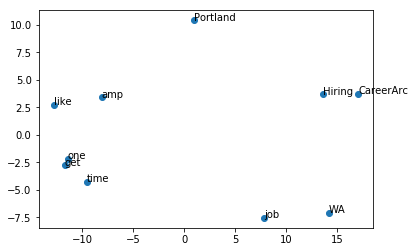

Region 20: tampa


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


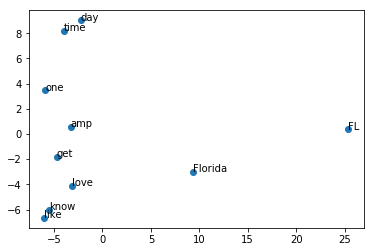

Region 21: toronto


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


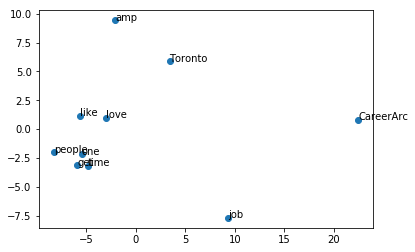

Region 22: washington


/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


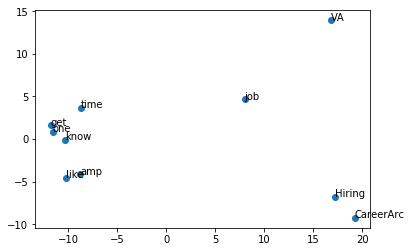

<Figure size 432x288 with 0 Axes>

In [70]:
# with 2.5M dataset
for region in regions_mapping.values():
    print('Region {}: {}'.format(region, idx2region[region]))
    data = df.loc[df.region == region]
    plot_word_embeddings(data.text.tolist(), region)

# Attention Translation Model

Although compression is an option, you can also do an expansion. Autoencoders are ostensibly tools for representation learning, where you try to find some intermediate feature vector representation for each of your data points so that the original data points can be retrieved as flawlessly as possible. I.e. the intermediate vector is ideally equivalent, but not identical, and contains the same amount of information as the datum. historically (as in, a few years ago), this was used for pretraining deep nets - one interpretation of a deep model is that it consists of a succession of nonlinear feature mappings (hidden layers) followed by a single linear classifier. The autoencoders thus have the same purpose as a deep net layer (find a nonlinear information-preserving feature mapping), and by training stacks of autoencoders (I.e. train one on the data, then train a new encoder on the hidden layer encoding of each data point, etc) you can get unsupervised deep net models, which can then be finetuned with supervised learning.

Auto encoders have an input layer, hidden layer, and an output layer. The input is forced to be as identical to the output, so its the hidden layer we are interested in.

The hidden layer form a kind of encoding of the input. "The aim of an auto-encoder is to learn a compressed, distributed representation (encoding) for a set of data." If input is a 100 dimensional vector, and you have 60 neurons in the hidden layer, then the auto encoder algorithm will replicate the input as a 100 dimensional vector in the output layer, in the process giving you a 60 dimensional vector that encodes your input.

So the purpose of auto encoders is dimensionality reduction, amongst many others.

It can also model your population so that when you input a new vector, you can check how different is the output from the input. If they're "quite" the same, you can assume the input matches the population. If they're "quite" different, then the input probably doesn't belong to the population you modeled.

I see it as a kind of "regression by neural networks" where you try to have a function describing your data: its output is the same as the input.

In [ ]:
import argparse
import sys

import tensorflow as tf
import opennmt as onmt
import numpy as np

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--model_dir", default="model",
                    help="Checkpoint directory.")

## Step 1
parser.add_argument("--src", required=True, help="Source file.")
parser.add_argument("--tgt", required=True, help="Target file.")
parser.add_argument("--src_trans", required=True, help="Source translation at the previous iteration.")
parser.add_argument("--tgt_trans", required=True, help="Target translation at the previous iteration.")
parser.add_argument("--src_vocab", required=True, help="Source vocabulary.")
parser.add_argument("--tgt_vocab", required=True, help="Target vocabulary.")

## Step 3
parser.add_argument("--src_emb", default=None, help="Source embedding.")
parser.add_argument("--tgt_emb", default=None, help="Target embedding.")

args = parser.parse_args()


# Step 1


from opennmt import constants
from opennmt.utils.misc import count_lines

def load_vocab(vocab_file):
  """Returns a lookup table and the vocabulary size."""
  vocab_size = count_lines(vocab_file) + 1  # Add UNK.
  vocab = tf.contrib.lookup.index_table_from_file(
      vocab_file,
      vocab_size=vocab_size - 1,
      num_oov_buckets=1)
  return vocab, vocab_size

def load_data(input_file,
              translated_file,
              input_vocab,
              translated_vocab,
              batch_size=32,
              max_seq_len=50,
              num_buckets=5):
  """Returns an iterator over the training data."""

  def _make_dataset(text_file, vocab):
    dataset = tf.data.TextLineDataset(text_file)
    dataset = dataset.map(lambda x: tf.string_split([x]).values)  # Split on spaces.
    dataset = dataset.map(vocab.lookup)  # Lookup token in vocabulary.
    return dataset

  def _key_func(x):
    bucket_width = (max_seq_len + num_buckets - 1) // num_buckets
    bucket_id = x["length"] // bucket_width
    bucket_id = tf.minimum(bucket_id, num_buckets)
    return tf.to_int64(bucket_id)

  def _reduce_func(unused_key, dataset):
    return dataset.padded_batch(batch_size, {
        "ids": [None],
        "ids_in": [None],
        "ids_out": [None],
        "length": [],
        "trans_ids": [None],
        "trans_length": []})

  bos = tf.constant([constants.START_OF_SENTENCE_ID], dtype=tf.int64)
  eos = tf.constant([constants.END_OF_SENTENCE_ID], dtype=tf.int64)

  # Make a dataset from the input and translated file.
  input_dataset = _make_dataset(input_file, input_vocab)
  translated_dataset = _make_dataset(translated_file, translated_vocab)
  dataset = tf.data.Dataset.zip((input_dataset, translated_dataset))
  dataset = dataset.shuffle(200000)

  # Define the input format.
  dataset = dataset.map(lambda x, y: {
      "ids": x,
      "ids_in": tf.concat([bos, x], axis=0),
      "ids_out": tf.concat([x, eos], axis=0),
      "length": tf.shape(x)[0],
      "trans_ids": y,
      "trans_length": tf.shape(y)[0]})

  # Filter out invalid examples.
  dataset = dataset.filter(lambda x: tf.greater(x["length"], 0))

  # Batch the dataset using a bucketing strategy.
  dataset = dataset.apply(tf.contrib.data.group_by_window(
      _key_func,
      _reduce_func,
      window_size=batch_size))
  return dataset.make_initializable_iterator()

src_vocab, src_vocab_size = load_vocab(args.src_vocab)
tgt_vocab, tgt_vocab_size = load_vocab(args.tgt_vocab)

with tf.device("/cpu:0"):  # Input pipeline should always be place on the CPU.
  src_iterator = load_data(args.src, args.src_trans, src_vocab, tgt_vocab)
  tgt_iterator = load_data(args.tgt, args.tgt_trans, tgt_vocab, src_vocab)
  src = src_iterator.get_next()
  tgt = tgt_iterator.get_next()


# Step 2


def add_noise_python(words, dropout=0.1, k=3):
  """Applies the noise model in input words.
  Args:
    words: A numpy vector of word ids.
    dropout: The probability to drop words.
    k: Maximum distance of the permutation.
  Returns:
    A noisy numpy vector of word ids.
  """

  def _drop_words(words, probability):
    """Drops words with the given probability."""
    length = len(words)
    keep_prob = np.random.uniform(size=length)
    keep = np.random.uniform(size=length) > probability
    if np.count_nonzero(keep) == 0:
      ind = np.random.randint(0, length)
      keep[ind] = True
    words = np.take(words, keep.nonzero())[0]
    return words

  def _rand_perm_with_constraint(words, k):
    """Randomly permutes words ensuring that words are no more than k positions
    away from their original position."""
    length = len(words)
    offset = np.random.uniform(size=length) * (k + 1)
    new_pos = np.arange(length) + offset
    return np.take(words, np.argsort(new_pos))

  words = _drop_words(words, dropout)
  words = _rand_perm_with_constraint(words, k)
  return words

def add_noise(ids, sequence_length):
  """Wraps add_noise_python for a batch of tensors."""

  def _add_noise_single(ids, sequence_length):
    noisy_ids = add_noise_python(ids[:sequence_length])
    noisy_sequence_length = len(noisy_ids)
    ids[:noisy_sequence_length] = noisy_ids
    ids[noisy_sequence_length:] = 0
    return ids, np.int32(noisy_sequence_length)

  noisy_ids, noisy_sequence_length = tf.map_fn(
      lambda x: tf.py_func(_add_noise_single, x, [ids.dtype, tf.int32]),
      [ids, sequence_length],
      dtype=[ids.dtype, tf.int32],
      back_prop=False)

  noisy_ids.set_shape(ids.get_shape())
  noisy_sequence_length.set_shape(sequence_length.get_shape())

  return noisy_ids, noisy_sequence_length


# Step 3


from opennmt.inputters.text_inputter import load_pretrained_embeddings

def create_embeddings(vocab_size, depth=300):
  """Creates an embedding variable."""
  return tf.get_variable("embedding", shape=[vocab_size, depth])

def load_embeddings(embedding_file, vocab_file):
  """Loads an embedding variable or embeddings file."""
  try:
    embeddings = tf.get_variable("embedding")
  except ValueError:
    pretrained = load_pretrained_embeddings(
        embedding_file,
        vocab_file,
        num_oov_buckets=1,
        with_header=True,
        case_insensitive_embeddings=True)
    embeddings = tf.get_variable(
        "embedding",
        shape=None,
        trainable=False,
        initializer=tf.constant(pretrained.astype(np.float32)))
  return embeddings

with tf.variable_scope("src"):
  if args.src_emb is not None:
    src_emb = load_embeddings(args.src_emb, args.src_vocab)
  else:
    src_emb = create_embeddings(src_vocab_size)

with tf.variable_scope("tgt"):
  if args.tgt_emb is not None:
    tgt_emb = load_embeddings(args.tgt_emb, args.tgt_vocab)
  else:
    tgt_emb = create_embeddings(tgt_vocab_size)


# Step 4


hidden_size = 512
encoder = onmt.encoders.BidirectionalRNNEncoder(2, hidden_size)

def add_noise_and_encode(ids, sequence_length, embedding, reuse=None):
  """Applies the noise model on ids, embeds and encodes.
  Args:
    ids: The tensor of words ids of shape [batch_size, max_time].
    sequence_length: The tensor of sequence length of shape [batch_size].
    embedding: The embedding variable.
    reuse: If True, reuse the encoder variables.
  Returns:
    A tuple (encoder output, encoder state, sequence length).
  """
  noisy_ids, noisy_sequence_length = add_noise(ids, sequence_length)
  noisy = tf.nn.embedding_lookup(embedding, noisy_ids)
  with tf.variable_scope("encoder", reuse=reuse):
    return encoder.encode(noisy, sequence_length=noisy_sequence_length)

src_encoder_auto = add_noise_and_encode(
    src["ids"], src["length"], src_emb, reuse=None)
tgt_encoder_auto = add_noise_and_encode(
    tgt["ids"], tgt["length"], tgt_emb, reuse=True)

src_encoder_cross = add_noise_and_encode(
    tgt["trans_ids"], tgt["trans_length"], src_emb, reuse=True)
tgt_encoder_cross = add_noise_and_encode(
    src["trans_ids"], src["trans_length"], tgt_emb, reuse=True)


# Step 5


decoder = onmt.decoders.AttentionalRNNDecoder(
    2, hidden_size, bridge=onmt.layers.CopyBridge())

from opennmt.utils.losses import cross_entropy_sequence_loss

def denoise(x, embedding, encoder_outputs, generator, reuse=None):
  """Denoises from the noisy encoding.
  Args:
    x: The input data from the dataset.
    embedding: The embedding variable.
    encoder_outputs: A tuple with the encoder outputs.
    generator: A tf.layers.Dense instance for projecting the logits.
    reuse: If True, reuse the decoder variables.
  Returns:
    The decoder loss.
  """
  with tf.variable_scope("decoder", reuse=reuse):
    logits, _, _ = decoder.decode(
        tf.nn.embedding_lookup(embedding, x["ids_in"]),
        x["length"] + 1,
        initial_state=encoder_outputs[1],
        output_layer=generator,
        memory=encoder_outputs[0],
        memory_sequence_length=encoder_outputs[2])
  cumulated_loss, _, normalizer = cross_entropy_sequence_loss(
      logits, x["ids_out"], x["length"] + 1)
  return cumulated_loss / normalizer

with tf.variable_scope("src"):
  src_gen = tf.layers.Dense(src_vocab_size)
  src_gen.build([None, hidden_size])

with tf.variable_scope("tgt"):
  tgt_gen = tf.layers.Dense(tgt_vocab_size)
  tgt_gen.build([None, hidden_size])

l_auto_src = denoise(src, src_emb, src_encoder_auto, src_gen, reuse=None)
l_auto_tgt = denoise(tgt, tgt_emb, tgt_encoder_auto, tgt_gen, reuse=True)

l_cd_src = denoise(src, src_emb, tgt_encoder_cross, src_gen, reuse=True)
l_cd_tgt = denoise(tgt, tgt_emb, src_encoder_cross, tgt_gen, reuse=True)


# Step 6


def binary_cross_entropy(x, y, smoothing=0, epsilon=1e-12):
  """Computes the averaged binary cross entropy.
  bce = y*log(x) + (1-y)*log(1-x)
  Args:
    x: The predicted labels.
    y: The true labels.
    smoothing: The label smoothing coefficient.
  Returns:
    The cross entropy.
  """
  y = tf.to_float(y)
  if smoothing > 0:
    smoothing *= 2
    y = y * (1 - smoothing) + 0.5 * smoothing
  return -tf.reduce_mean(tf.log(x + epsilon) * y + tf.log(1.0 - x + epsilon) * (1 - y))

def discriminator(encodings,
                  sequence_lengths,
                  lang_ids,
                  num_layers=3,
                  hidden_size=1024,
                  dropout=0.3):
  """Discriminates the encoder outputs against lang_ids.
  Args:
    encodings: The encoder outputs of shape [batch_size, max_time, hidden_size].
    sequence_lengths: The length of each sequence of shape [batch_size].
    lang_ids: The true lang id of each sequence of shape [batch_size].
    num_layers: The number of layers of the discriminator.
    hidden_size: The hidden size of the discriminator.
    dropout: The dropout to apply on each discriminator layer output.
  Returns:
    A tuple with: the discriminator loss (L_d) and the adversarial loss (L_adv).
  """
  x = encodings
  for _ in range(num_layers):
    x = tf.nn.dropout(x, 1.0 - dropout)
    x = tf.layers.dense(x, hidden_size, activation=tf.nn.leaky_relu)
  x = tf.nn.dropout(x, 1.0 - dropout)
  y = tf.layers.dense(x, 1)

  mask = tf.sequence_mask(
      sequence_lengths, maxlen=tf.shape(encodings)[1], dtype=tf.float32)
  mask = tf.expand_dims(mask, -1)

  y = tf.log_sigmoid(y) * mask
  y = tf.reduce_sum(y, axis=1)
  y = tf.exp(y)

  l_d = binary_cross_entropy(y, lang_ids, smoothing=0.1)
  l_adv = binary_cross_entropy(y, 1 - lang_ids)

  return l_d, l_adv

from opennmt.layers.reducer import pad_in_time

batch_size = tf.shape(src["length"])[0]
all_encoder_outputs = [
    src_encoder_auto, src_encoder_cross,
    tgt_encoder_auto, tgt_encoder_cross]
lang_ids = tf.concat([
    tf.fill([batch_size * 2], 0),
    tf.fill([batch_size * 2], 1)], 0)

max_time = tf.reduce_max([tf.shape(output[0])[1] for output in all_encoder_outputs])

encodings = tf.concat([
    pad_in_time(output[0], max_time - tf.shape(output[0])[1])
    for output in all_encoder_outputs], 0)
sequence_lengths = tf.concat([output[2] for output in all_encoder_outputs], 0)

with tf.variable_scope("discriminator"):
  l_d, l_adv = discriminator(encodings, sequence_lengths, lang_ids)


# Step 7


lambda_auto = 1
lambda_cd = 1
lambda_adv = 1

l_auto = l_auto_src + l_auto_tgt
l_cd = l_cd_src + l_cd_tgt

l_final = (lambda_auto * l_auto + lambda_cd * l_cd + lambda_adv * l_adv)

def build_train_op(global_step, encdec_variables, discri_variables):
  """Returns the training Op.
  When global_step % 2 == 0, it minimizes l_final and updates encdec_variables.
  Otherwise, it minimizes l_d and updates discri_variables.
  Args:
    global_step: The training step.
    encdec_variables: The list of variables of the encoder/decoder model.
    discri_variables: The list of variables of the discriminator.
  Returns:
    The training op.
  """
  encdec_opt = tf.train.AdamOptimizer(learning_rate=0.0003, beta1=0.5)
  discri_opt = tf.train.RMSPropOptimizer(0.0005)
  encdec_gradients = encdec_opt.compute_gradients(l_final, var_list=encdec_variables)
  discri_gradients = discri_opt.compute_gradients(l_d, var_list=discri_variables)
  return tf.cond(
      tf.equal(tf.mod(global_step, 2), 0),
      true_fn=lambda: encdec_opt.apply_gradients(encdec_gradients, global_step=global_step),
      false_fn=lambda: discri_opt.apply_gradients(discri_gradients, global_step=global_step))

encdec_variables = []
discri_variables = []
for variable in tf.trainable_variables():
  if variable.name.startswith("discriminator"):
    discri_variables.append(variable)
  else:
    encdec_variables.append(variable)

global_step = tf.train.get_or_create_global_step()
train_op = build_train_op(global_step, encdec_variables, discri_variables)

i = 0
with tf.train.MonitoredTrainingSession(checkpoint_dir=args.model_dir) as sess:
  sess.run([src_iterator.initializer, tgt_iterator.initializer])
  while not sess.should_stop():
    if i % 2 == 0:
      _, step, _l_auto, _l_cd, _l_adv, _l = sess.run(
          [train_op, global_step, l_auto, l_cd, l_adv, l_final])
      print("{} - l_auto = {}; l_cd = {}, l_adv = {}; l = {}".format(
          step, _l_auto, _l_cd, _l_adv, _l))
    else:
      _, step, _l_d = sess.run([train_op, global_step, l_d])
      print("{} - l_d = {}".format(step, _l_d))
    i += 1
    sys.stdout.flush()

# Unsupervised Translation Model



In [ ]:
model_dir=unsupervised-nmt-enfr
data_dir=data/unsupervised-nmt-enfr

src_vocab=${data_dir}/en-vocab.txt
tgt_vocab=${data_dir}/fr-vocab.txt
src_emb=${data_dir}/wmt14m.en300.vec
tgt_emb=${data_dir}/wmt14m.fr300.vec

src=${data_dir}/train.en
tgt=${data_dir}/train.fr
src_trans=${data_dir}/train.en.m1
tgt_trans=${data_dir}/train.fr.m1

src_test=${data_dir}/newstest2014.en.tok
tgt_test=${data_dir}/newstest2014.fr.tok
src_test_trans=${data_dir}/newstest2014.en.tok.m1
tgt_test_trans=${data_dir}/newstest2014.fr.tok.m1

timestamp=$(date +%s)
score_file=scores-${timestamp}.txt

In [ ]:
python ref/training.py \
           --model_dir ${model_dir} \
           --src ${src} \
           --tgt ${tgt} \
           --src_trans ${src_trans} \
           --tgt_trans ${tgt_trans} \
           --src_vocab ${src_vocab} \
           --tgt_vocab ${tgt_vocab} \
           --src_emb ${src_emb} \
           --tgt_emb ${tgt_emb}

In [83]:
src_iterator = load_data(src/input_file=train.en, 
                         src_trans/translated_file=train.en.m1, 
                         src_vocab/input_vocab=en-vocab.txt, 
                         tgt_vocab/translated_vocab=fr-vocab.txt)

SyntaxError: keyword can't be an expression (<ipython-input-83-ff3f4044e580>, line 1)

In [84]:
print(constants.START_OF_SENTENCE_ID)
print(constants.END_OF_SENTENCE_ID)

1
2


In [85]:
bos = tf.constant([constants.START_OF_SENTENCE_ID], dtype=tf.int64)
eos = tf.constant([constants.END_OF_SENTENCE_ID], dtype=tf.int64)

In [ ]:
src_dataset = 